# Context
This notebook drives the training process for different models.

# Score analysis

In [39]:
# Set project's environment variables
import os
import sys
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../../project.env")
sys.path.append(os.environ["PYTHONPATH"])

In [40]:
# Import project-wide and PH2 specific variables and functions
import superheader as sup

In [41]:
scores_path = os.path.join(sup.SCORES_ROOT, "specified", sup.TRAIN_BERT_CODE, "PREPanalysis5.csv")

top_barrier=2

## Helper functions

In [42]:
import math

def significance(row, score_col):
  C = int(row["num_classes"])
  score = row[score_col]

  k = 2 if score_col == 'top2accuracy' else 1
  if C == k:
    return 0
  
  # Chance the true class appears in a random top-k set:
  # Choose (k - 1) other classes from the remaining (C - 1), then divide by all
  # possible top-k sets
  # chance_score = math.comb(C - 1, k - 1)  /  math.comb(C, k)
  #       "      = ((C-1)! / ((C-1-(k-1))! * (k-1)!))  /  (C! / ((C-k)! * k!))
  #       "      = ((C-1)! / ((C-k)! * (k-1)!))  /  (C! / ((C-k)! * k!))
  #       "      = ((C-1)! / (k-1)!)  /  (C! / k!)
  #       "      = ((C-1)! / C!)  /  ((k-1)! / k!)
  #       "      = (k! / (k-1)!) / (C! / (C-1)!)
  #       "      = k / C
  # So:
  chance_score = k / C

  if score_col == 'accuracy' or score_col == 'top2accuracy':
    std = math.sqrt(chance_score * (1 - chance_score) / 100 * C)
  elif score_col == 'macro_recall':
    std = math.sqrt((1 - chance_score) / (100 * C**2))
  elif score_col == 'macro_precision':
    std = math.sqrt((C - 1) / (100 * C**2))

  z = (score - chance_score)/std

  return z

def harmonic_z(row, recall_col='macro_recall_z', precision_col='macro_precision_z'):
    recall_z = row[recall_col]
    precision_z = row[precision_col]

    # Handle zero or undefined cases
    if recall_z + precision_z == 0:
        return 0  # or np.nan if you want to mark it

    return 2 * recall_z * precision_z / (recall_z + precision_z)
                

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize(df, group_cols, top, sortby='accuracy', filter_cols=None, filter_values=None):
    """
    Optionally filters df by filter_cols == filter_values, groups by group_cols,
    selects top `top` rows by selected sortby metric, computes mean metric, and plots the result.
    """
    filter_desc = ""

    # Filter if needed
    if filter_cols and filter_values:
        for col, val in zip(filter_cols, filter_values):
            df = df[df[col] == val]
        filter_desc = " | " + " & ".join(f"{col}={val}" for col, val in zip(filter_cols, filter_values))

    # Group, take top `top` by selected sortby metric, compute mean
    mean_scores = (
        df.groupby(group_cols)
          .apply(lambda g: g.sort_values(sortby, ascending=False).head(top)[sortby].mean())
          .reset_index(name=f'mean_{sortby}')
    )

    # Create simple string labels for the x-axis
    mean_scores['label'] = mean_scores[group_cols].astype(str).agg(' | '.join, axis=1)

    # Plot
    colors = sns.color_palette("muted", len(mean_scores))
    plt.figure(figsize=(10, 6))
    plt.bar(mean_scores['label'], mean_scores[f'mean_{sortby}'], color=colors)

    plt.ylabel(f"Mean {sortby} (Top {top})")
    plt.title(f"Top {top} Mean {sortby} per {' + '.join(group_cols)}{filter_desc}")
    plt.xticks(rotation=45, ha='right')

    # Set y-limits with padding
    min_val = mean_scores[f'mean_{sortby}'].min()
    max_val = mean_scores[f'mean_{sortby}'].max()
    padding = (max_val - min_val) * 0.3  # 10% padding
    #plt.ylim(max(min_val - padding, 0), min(max_val + padding, 1))

    # Add values on bars
    for i, val in enumerate(mean_scores[f'mean_{sortby}']):
        plt.text(i, val + padding*0.002, f"{val:.3f}", ha='center', va='bottom', fontsize=6)

    plt.tight_layout()
    plt.show()


## Data

In [44]:
import pandas as pd

In [45]:
knn_scores_df = pd.read_csv(scores_path)
knn_scores_df.sort_values(by="top2accuracy", ascending=False)

,data_unit,PH2,num_classes,difficulty,accuracy,top2accuracy,macro_f1,macro_precision,macro_recall
0,Spf,False,2,easy,0.989540,1.000000,0.989470,0.990014,0.989005
15,Spf,True,2,easy,0.930962,1.000000,0.930500,0.930981,0.930093
47,Spv,True,2,hard,0.744186,1.000000,0.739106,0.758102,0.741342
46,Spv,True,2,average,0.976744,1.000000,0.976744,0.977273,0.977273
45,Spv,True,2,easy,0.875000,1.000000,0.873016,0.875959,0.871212
36,Spv,False,6,easy,0.870968,1.000000,0.862633,0.895404,0.862738
32,Spv,False,2,hard,0.651163,1.000000,0.650407,0.654605,0.652597
31,Spv,False,2,average,0.906977,1.000000,0.906926,0.909783,0.908009
1,Spf,False,2,average,0.974609,1.000000,0.974609,0.974623,0.974601
17,Spf,True,2,hard,0.782946,1.000000,0.781498,0.789960,0.782642


In [46]:
for metric_name in ['accuracy', 'top2accuracy', 'macro_precision', 'macro_recall']:
  knn_scores_df[f'{metric_name}_z'] = knn_scores_df.apply(lambda x: significance(x, metric_name), axis=1)

knn_scores_df['harmonic_z'] = knn_scores_df.apply(harmonic_z, axis=1)

knn_scores_df

,data_unit,PH2,num_classes,difficulty,accuracy,top2accuracy,macro_f1,macro_precision,macro_recall,accuracy_z,top2accuracy_z,macro_precision_z,macro_recall_z,harmonic_z
0,Spf,False,2,easy,0.989540,1.000000,0.989470,0.990014,0.989005,6.923138,0.000000,9.800282,13.831142,11.471936
1,Spf,False,2,average,0.974609,1.000000,0.974609,0.974623,0.974601,6.711990,0.000000,9.492462,13.423754,11.120900
2,Spf,False,2,hard,0.755814,1.000000,0.741852,0.823808,0.754924,3.617756,0.000000,6.476156,7.210337,6.823555
3,Spf,False,4,easy,0.911344,0.980934,0.911992,0.917595,0.911511,7.636544,4.809342,15.417445,30.553879,20.493765
4,Spf,False,4,average,0.942439,0.982439,0.942348,0.942925,0.942834,7.995597,4.824390,16.002410,32.000613,21.335612
5,Spf,False,4,hard,0.973790,0.983871,0.973733,0.974415,0.973504,8.357611,4.838710,16.729641,33.417214,22.296832
6,Spf,False,6,easy,0.949461,0.987197,0.949834,0.951139,0.950088,8.575081,5.662623,21.049599,51.491677,29.883102
7,Spf,False,6,average,0.959530,0.986292,0.959736,0.960948,0.959463,8.685383,5.654792,21.312811,52.107888,30.252111
8,Spf,False,6,hard,0.895722,0.985294,0.890740,0.900149,0.889827,7.986400,5.646146,19.681389,47.530947,27.836409
9,Spf,False,8,easy,0.971344,0.988636,0.971530,0.971824,0.971448,9.047797,6.030941,25.605547,72.391240,37.830164


### Inital number-of-classes-agnostic analysis

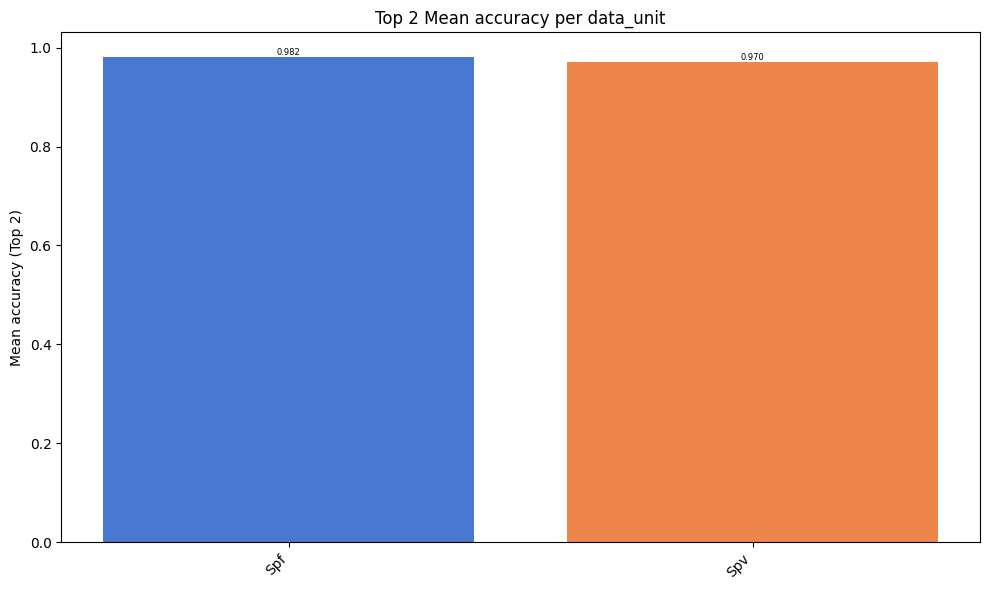

In [47]:
visualize(knn_scores_df, group_cols=['data_unit'], top=top_barrier)

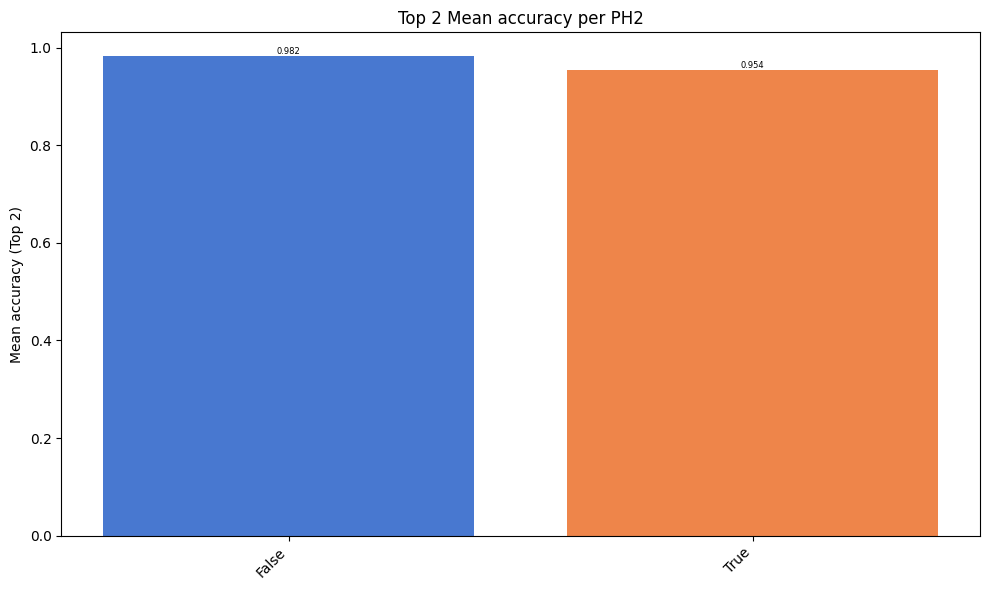

In [48]:
visualize(knn_scores_df, group_cols=['PH2'], top=top_barrier)

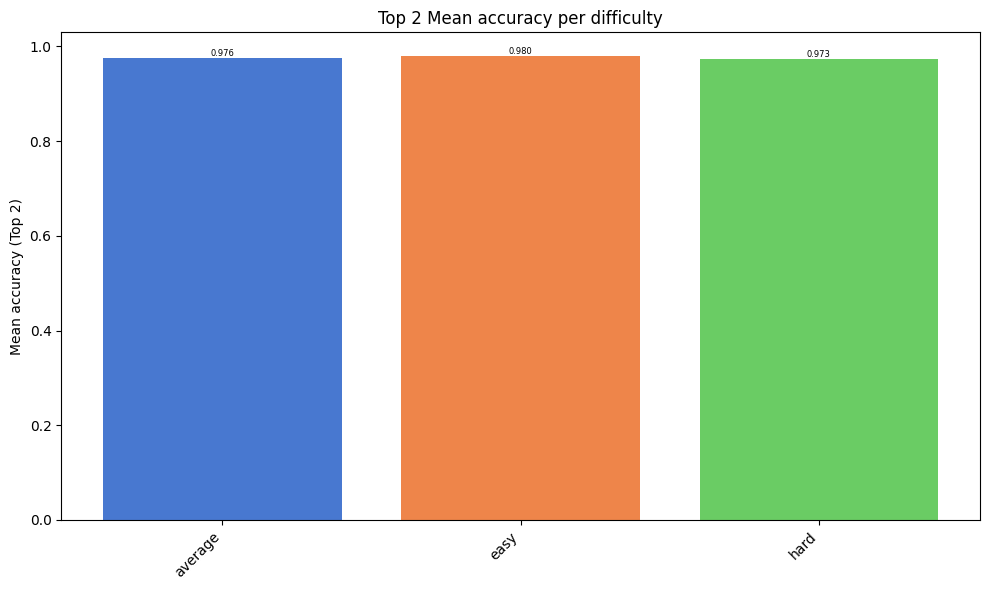

In [49]:
visualize(knn_scores_df, group_cols=['difficulty'], top=top_barrier, sortby='accuracy')

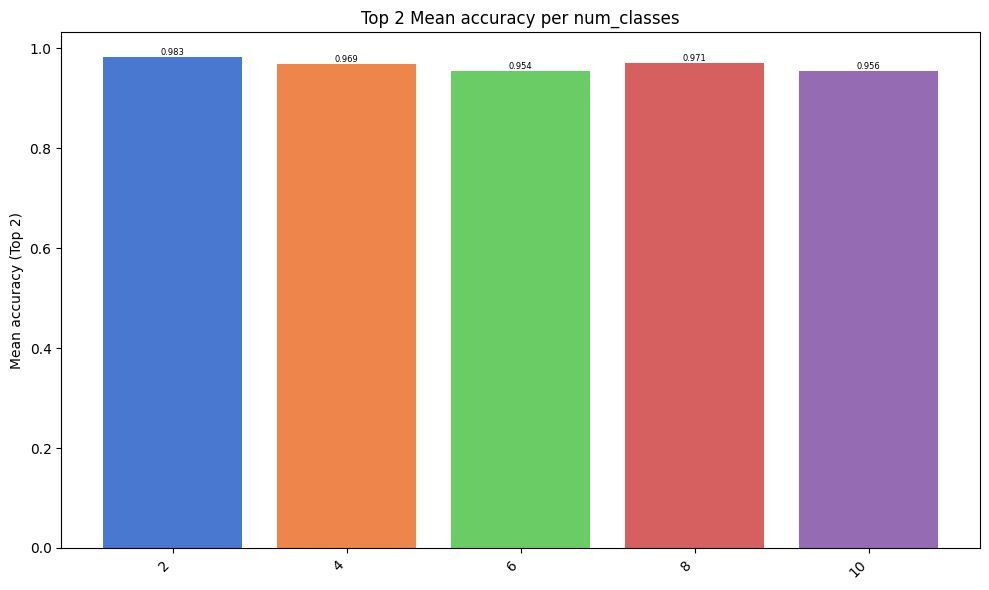

In [50]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier)

### Intial analysis compensanting for number of classes

#### data_unit

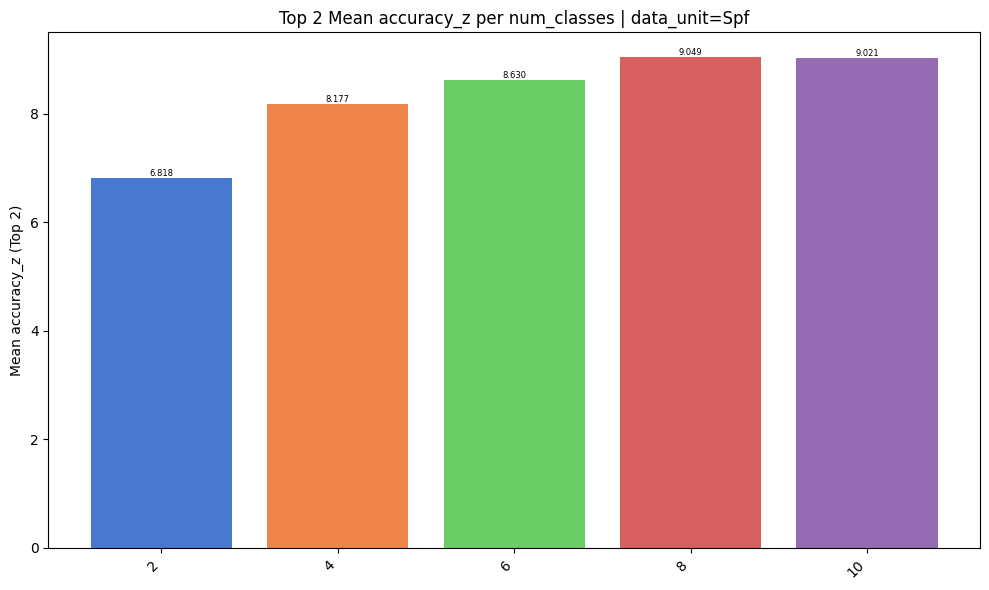

In [51]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF], sortby='accuracy_z')

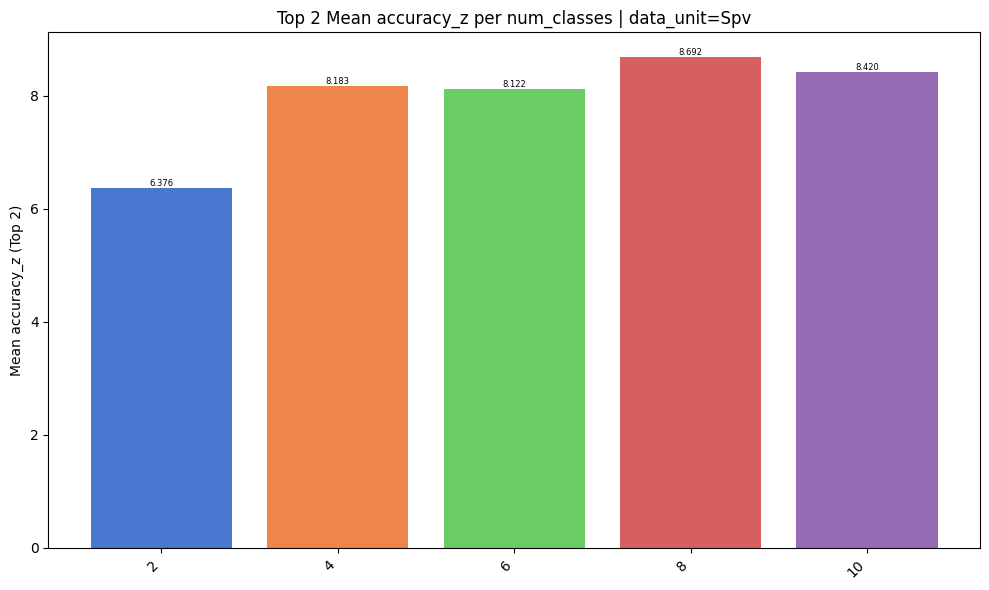

In [52]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV], sortby='accuracy_z')

#### PH2

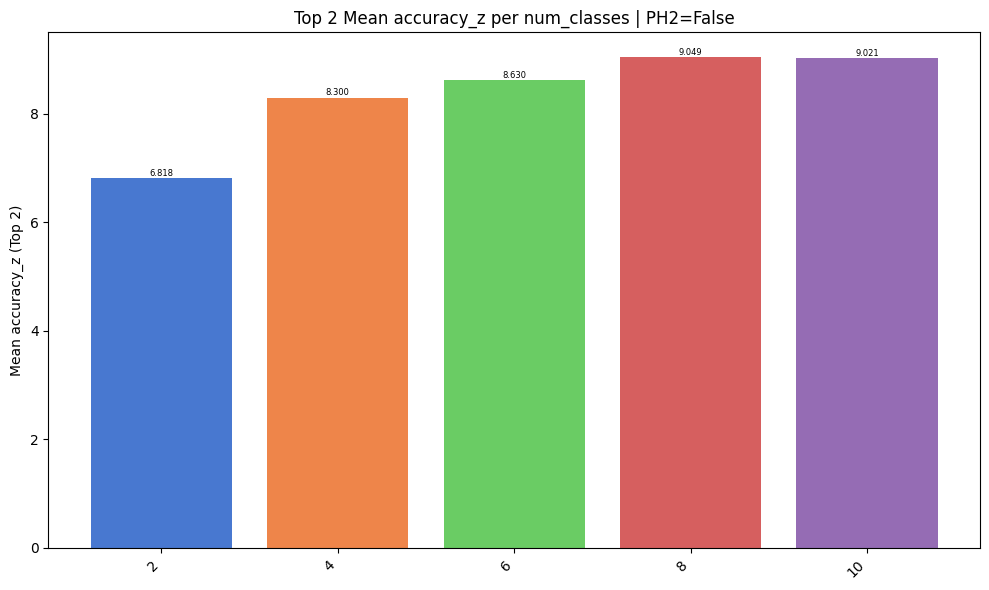

In [53]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['PH2'], filter_values=[False], sortby='accuracy_z')

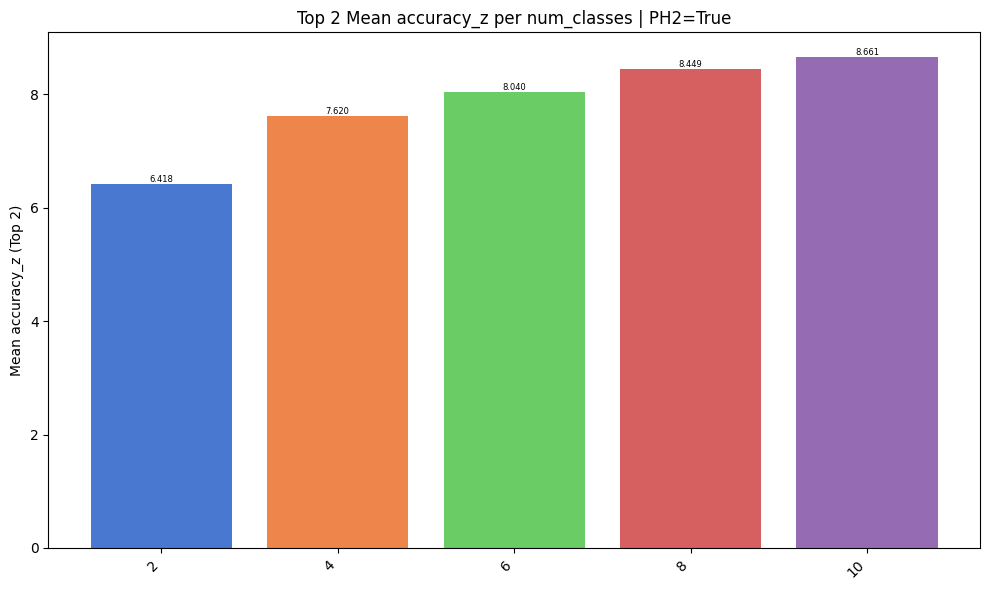

In [54]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['PH2'], filter_values=[True], sortby='accuracy_z')

#### difficulty

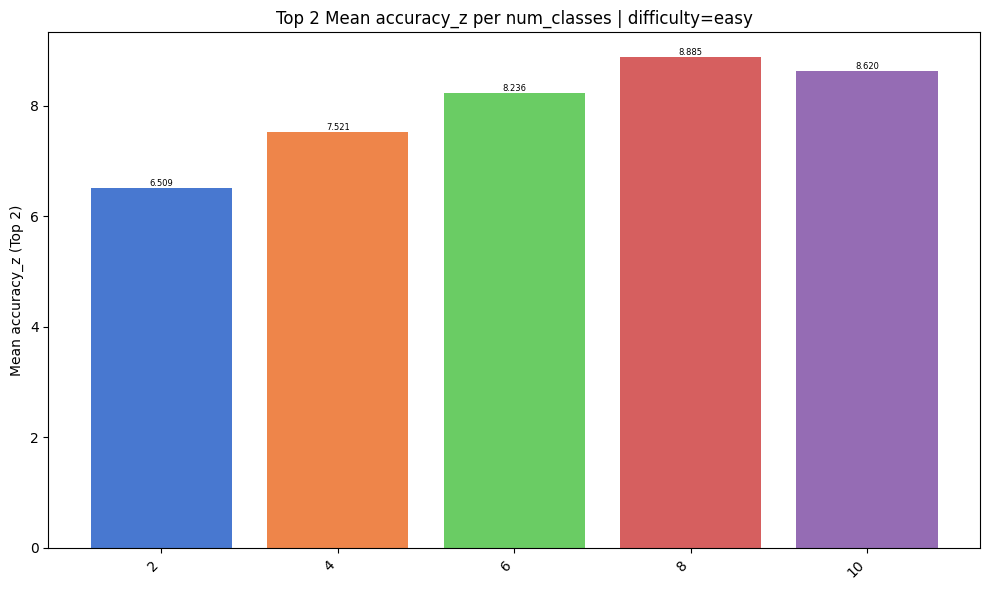

In [55]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['difficulty'], filter_values=['easy'], sortby='accuracy_z')

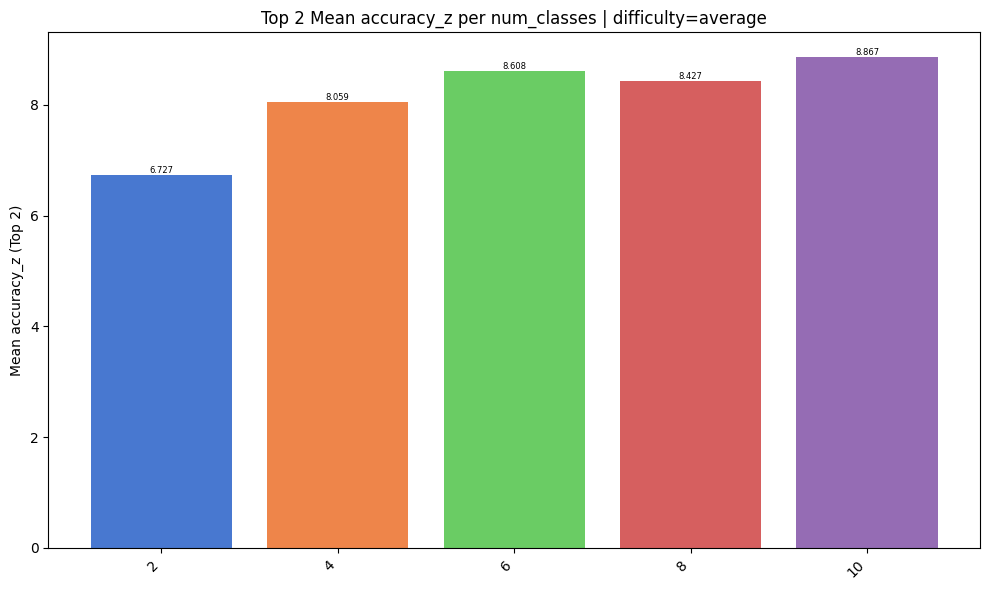

In [56]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['difficulty'], filter_values=['average'], sortby='accuracy_z')

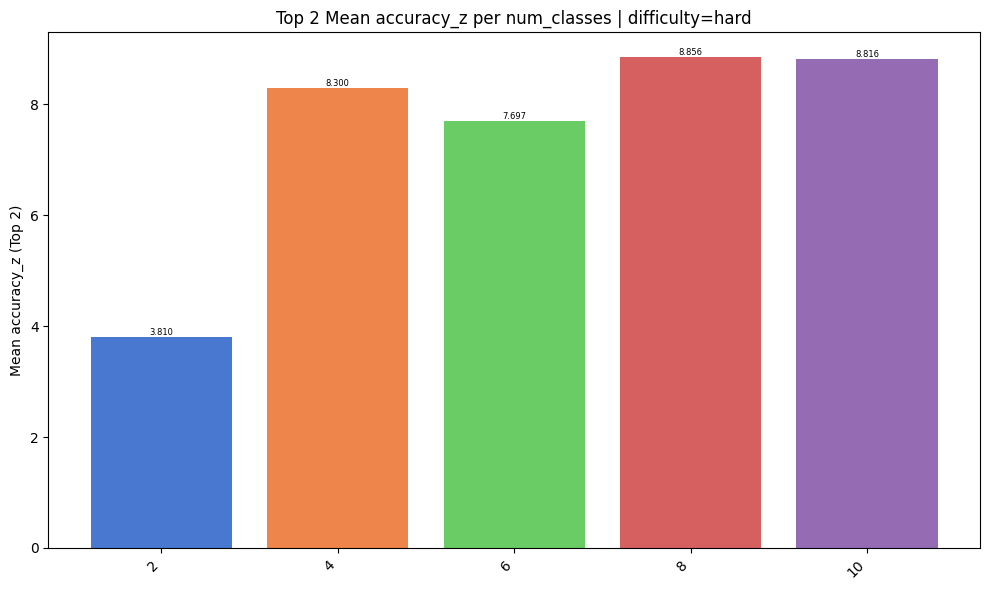

In [57]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['difficulty'], filter_values=['hard'], sortby='accuracy_z')

### Same but with harmonization of significance or recall and precision

#### data_unit

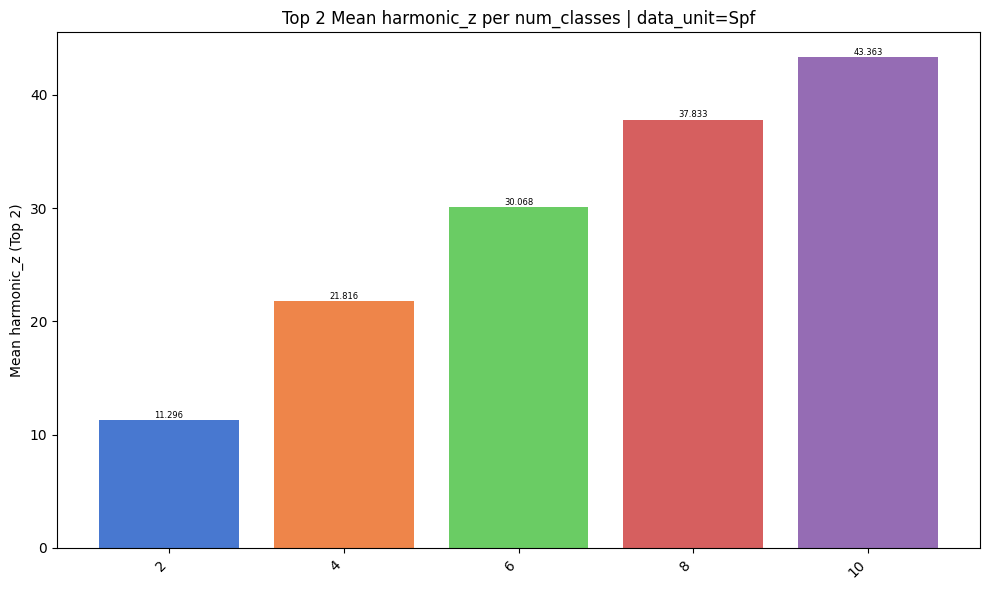

In [58]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF], sortby='harmonic_z')

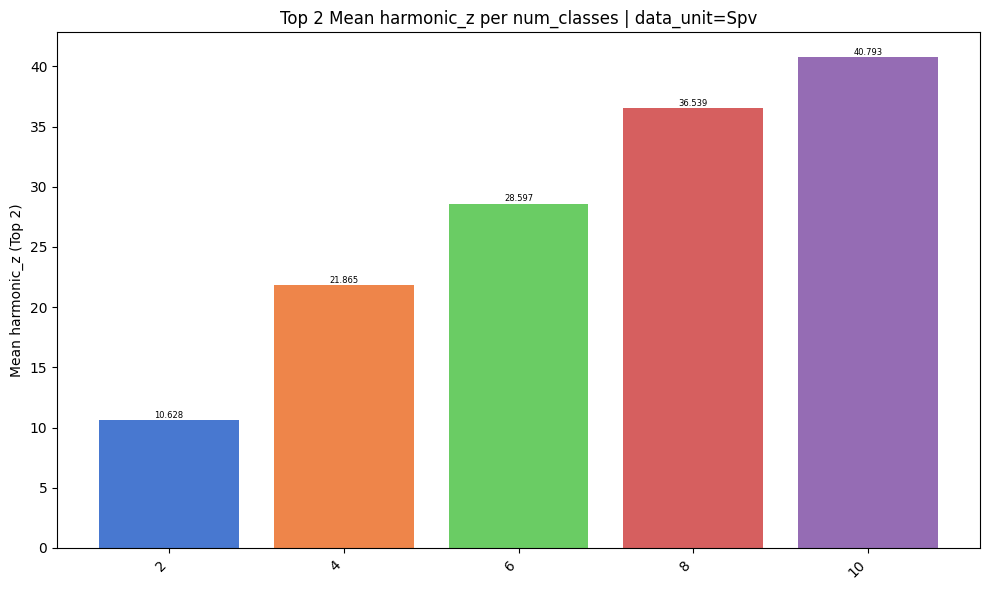

In [59]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV], sortby='harmonic_z')

#### PH2

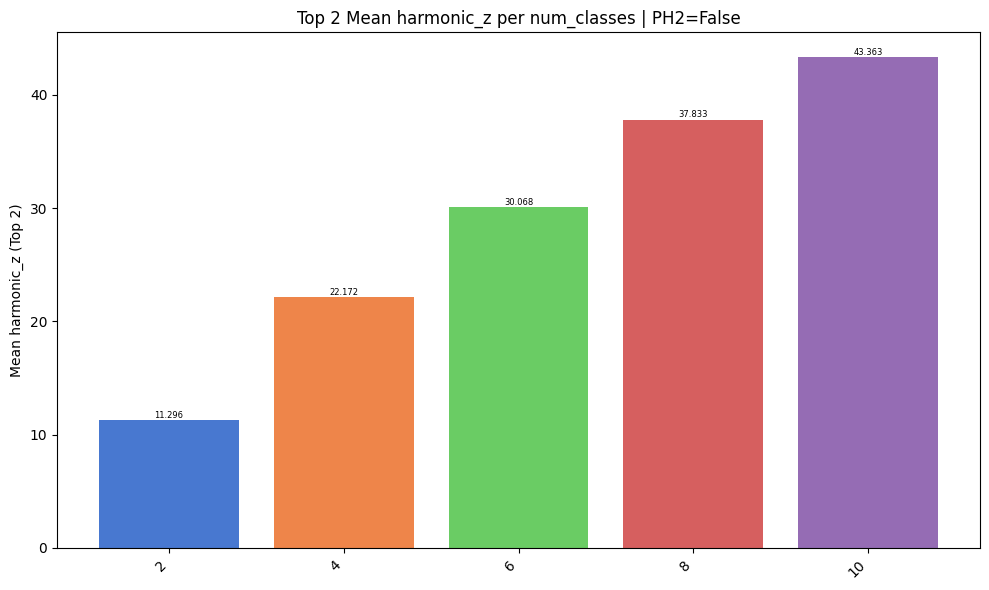

In [60]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['PH2'], filter_values=[False], sortby='harmonic_z')

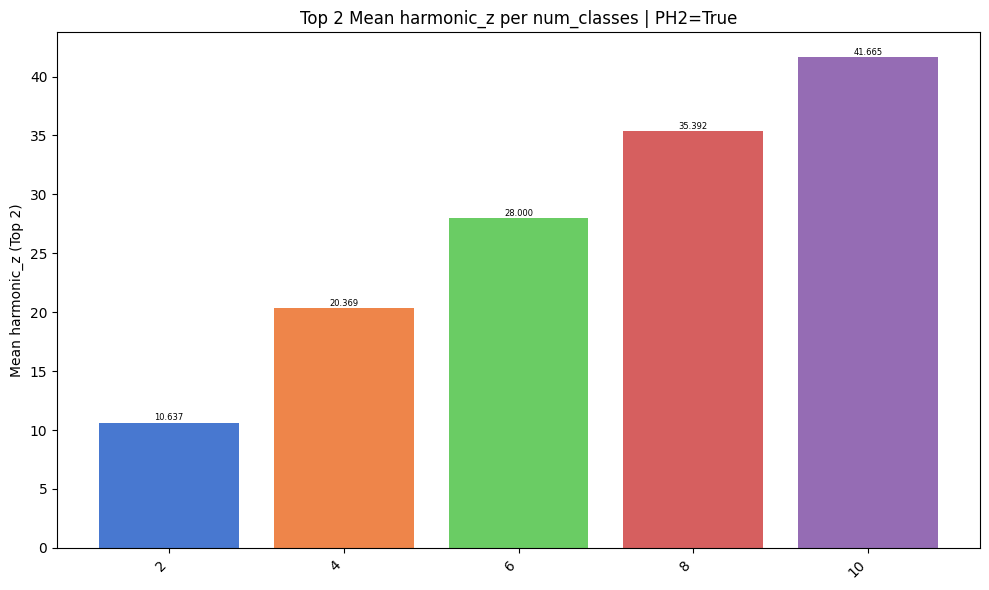

In [61]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['PH2'], filter_values=[True], sortby='harmonic_z')

#### difficulty

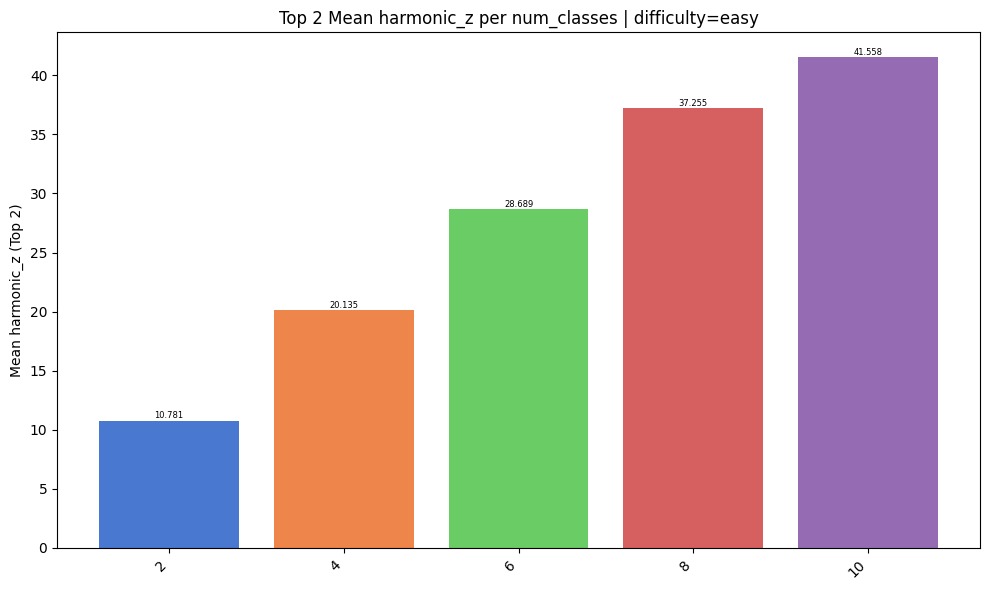

In [62]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['difficulty'], filter_values=['easy'], sortby='harmonic_z')

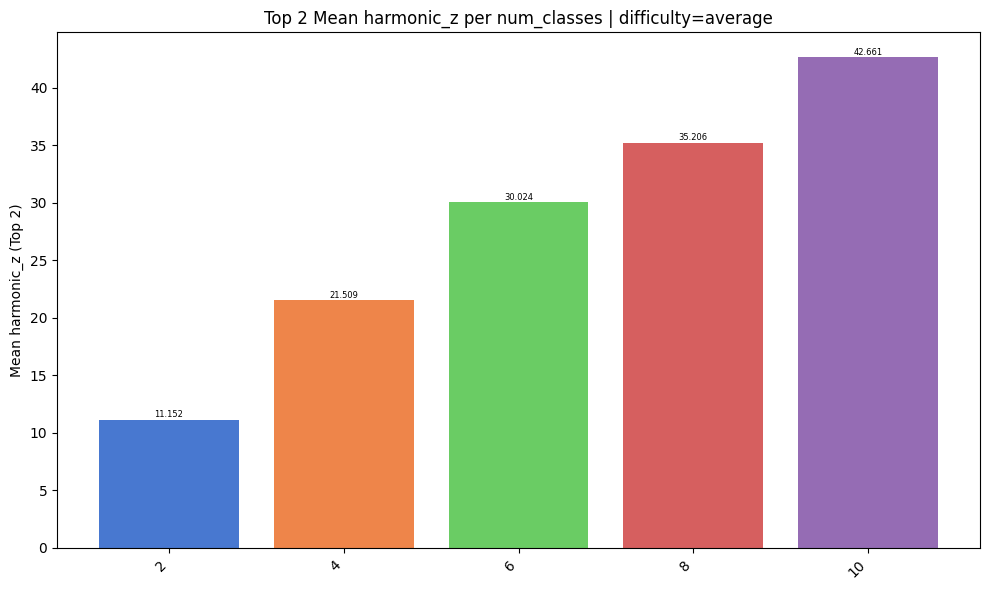

In [63]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['difficulty'], filter_values=['average'], sortby='harmonic_z')

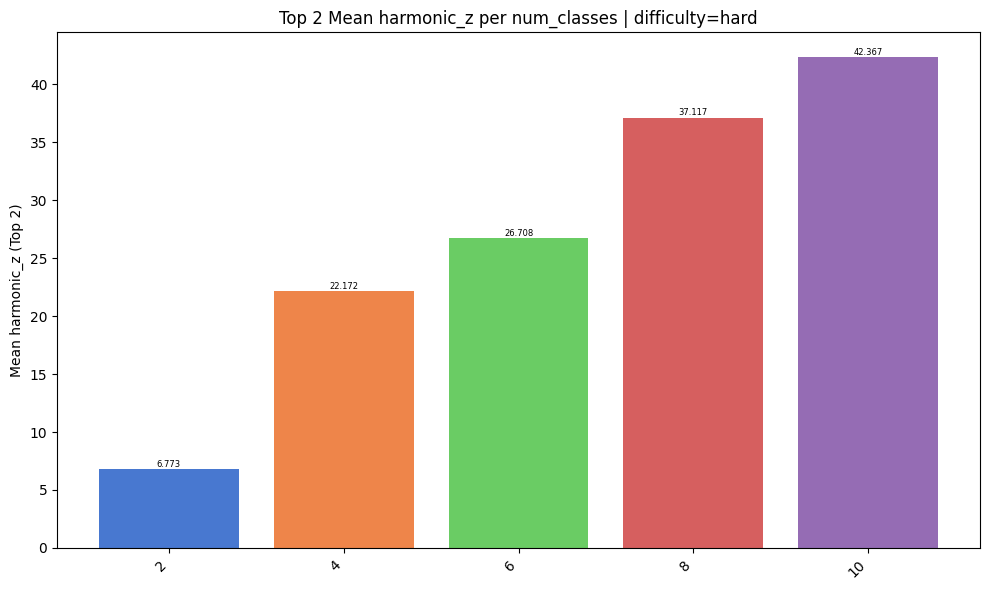

In [64]:
visualize(knn_scores_df, group_cols=['num_classes'], top=top_barrier, filter_cols=['difficulty'], filter_values=['hard'], sortby='harmonic_z')